# Classification (1) – an issue with distance measures, and an implementation of Nearest Neighbour classification

## Introduction

In this notebook we will expand on some of the concepts of 
classification, starting with an experiment with distance measures on data, then looking into the $k$-Nearest Neighbour algorithm. 

## 1) Distance measures for high-dimensionality data

Algorithms such as $k$-Nearest Neighbour are conceptually very simple -- we predict the class value of an unlabelled *query* data point we are given by looking at all the labelled data point(s) in our data set, and predicting that our query will have the same class as the most similar data point(s) in the training set. So, all we need is a way of measuring similarity. The well-known *Euclidean distance measure* would seem to be a good choice. However, while we are very familiar with Euclidean distance in 2 and 3-dimensions, there was a warning (Slide 62 of the "Classification (1)" lecture) that in high-dimensions there is a problem – what was this problem ? 

### Pairwise distances in high-dimensional spaces 

**Answer**: in high-dimensional spaces everything is far away from everything else, and so pairwise distances become uninformative.

But what does this actually mean ? There is a mathematical argument to show that this is a true statement, but an alternative approach is simply to simulate what happens. One approach is to randomly generate $N$ points inside a $d$-dimensional cube centred around zero, such as $[-0.5, 0.5]^{d}$. Now we calculate the pairwise distances among the $N$ points.  After that for every data point we calculate the ratio of the minimum distance to the maximum distance  to all of the other data points. The mean ratio represents the average range of pairwise distances there are in that dimensionality. We run the simulation from 1 dimension to 1000 dimensions and the ratios will be plotted on a line chart using the ``` matplotlib ``` library. 

You should use the ```numpy``` library for this, and in particular the linear algebra methods to calculate distances such as the [L2 norm](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm). 

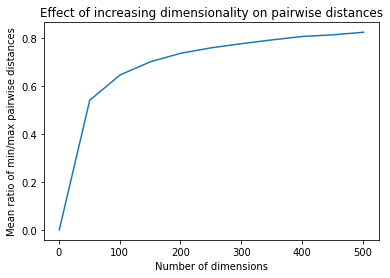

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def run_d_n(dim,N_pts,L):
    pts=np.random.rand(N_pts,dim)-0.5 # simulate N_pts points on dim dimensions space
    ratio_list=[]
    for i in range(N_pts):
        # ignore the data point itself
        selected_pts=np.array([j for j in range(N_pts) if j!=i])
        # calculate the L2 or L1 distance with other points
        dist=np.linalg.norm(pts[selected_pts]-pts[i],L,axis=1)
        # calculate the ratio of the min. distance to the max. distance
        ratio=np.min(dist)/np.max(dist)
        ratio_list.append(ratio)
    # output the mean ratio
    return np.mean(ratio_list)

# Initialise the N_pts, the number of points we simulate
N_pts=1000
# Setting l=2 to calculate the L2 distance
l=1
# Setting the number of dimensions we simulate
check_dim=range(1,550,50)
# Calculate the mean ratio on that dimension
ratio_list=[ run_d_n(dim,N_pts,l) for dim in check_dim]
# Plot the ratio with its corresponding dimension
plt.plot(check_dim,ratio_list)
plt.ylabel("Mean ratio of min/max pairwise distances")
plt.xlabel("Number of dimensions")
plt.title("Effect of increasing dimensionality on pairwise distances")
plt.xticks(np.arange(0, 600, step=100))
plt.show()

**Question:** how can this plot be interpreted ? How else could you visualize this effect ?

We can interpret this as showing that as dimensionality increases the min. and max. distances from any point to any other point become more similar. Something this plot doesn't show is the  distribution of the actual distances. To see this you could try plotting histograms of the distribution of all pairwise distances for a set of points of low, then higher dimensionality. If you do this, first think about how you would expect it to look.

## 2) Implement Nearest Neighbour from scratch

The following will give some practise in implementing a simple classifier, the $k$-Nearest Neighbour ($k$NN) algorithm. It should help us to write a $k$NN package from scratch. Most machine learning methods include two main steps, namely training (fitting to a model to the training data) and prediction (running the model on input data  to generate output). However, in the $k$NN algorithm, since there is no explicit model-building step, we only require implementation of the prediction step without a training step.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Data Creation

In [3]:
mean_01 = np.array([1, 0.5])
cov_01 = np.array([[1, 0.1], [0.1, 1.2]])

mean_02 = np.array([4, 5])
cov_02 = np.array([[1, 0.1], [0.1, 1.2]])

dist_01 = np.random.multivariate_normal(mean_01, cov_01, 500)
dist_02 = np.random.multivariate_normal(mean_02, cov_02, 500)
print(dist_01.shape, dist_02.shape)

(500, 2) (500, 2)


We have created two 2-dimensional normal distributions of data points with the same covariance but different means.

## Plotting the created Data 

What does the data look like ? Notice the 2 unique clusters being formed.

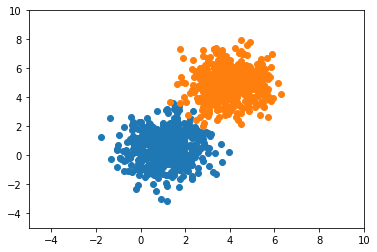

In [4]:
plt.figure(0)
plt.xlim(-5, 10)
plt.ylim(-5, 10)

plt.scatter(dist_01[:, 0], dist_01[:, 1])
plt.scatter(dist_02[:, 0], dist_02[:, 1])#, color='red')
plt.show()

Let us now represent it in a tabular way. We will have dist_01 getting label 1.

In [5]:
r = dist_01.shape[0] + dist_02.shape[0]
c = dist_01.shape[1] + 1
data = np.zeros((r, c))
print(data.shape)

data[:dist_01.shape[0], :2] = dist_01
data[dist_01.shape[0]:, :2] = dist_02
data[dist_01.shape[0]:, -1] = 1.0

print(data.mean(axis=0))

(1000, 3)
[2.51806963 2.74151088 0.5       ]


Now shuffle the data and check by printing the first 10 rows.

In [6]:
np.random.shuffle(data)
print(data[:10])

[[ 1.93780828  2.22819103  0.        ]
 [ 1.00180484 -0.54050878  0.        ]
 [-0.11075751  0.21513366  0.        ]
 [ 4.28371769  3.55341791  1.        ]
 [ 0.76785114  0.27328954  0.        ]
 [ 4.47804924  5.5749638   1.        ]
 [ 3.71995844  3.93665721  1.        ]
 [ 1.65283549  4.89767494  1.        ]
 [ 1.57168591  1.45158486  0.        ]
 [ 4.00668429  5.14312621  1.        ]]


**Implementation.** Next, we implement our KNN algorithm. There are many ways to do this, but a basic approach will require a pairwise distance measure for instances, and a way to take a "training" dataset of classified instances and make a prediction for a "test" data instance. Here is a top-level outline:

In [1]:
def distance(x1, x2):
    d = np.sqrt(((x1-x2)**2).sum())
    return d

def knn(X_train, y_train, xt, k=7):
    vals = []
    for ix in range(X_train.shape[0]):
        d = distance(X_train[ix], xt)
        vals.append([d, y_train[ix]])
    sorted_labels = sorted(vals, key=lambda z: z[0])
    neighbours = np.asarray(sorted_labels)[:k, -1]
    
    freq = np.unique(neighbours, return_counts=True)
    
    return freq[0][freq[1].argmax()]

Now check to see if we can make a prediction.

In [8]:
test_point = np.array([8, -4])

# Un-comment the line below and check if it comes out as 0.0  
print(knn(data[:, :2], data[:, -1], test_point))

0.0


## Create a train and test split of the data

In [9]:
np.random.shuffle(data)
split = int(0.75 * data.shape[0])
# print split
train_data_X = data[:split, :2]
train_data_y = data[:split, -1]
test_data_X = data[split:, :2]
test_data_y = data[split:, -1]

print(train_data_X.shape, train_data_y.shape)
print(test_data_X.shape, test_data_y.shape)

(750, 2) (750,)
(250, 2) (250,)


**Implementation.** Next we need to implement some way to run our KNN classifier on all the test data and get the results. 

In [10]:
def get_acc(kx):
    preds = []
    # print kx
    for ix in range(test_data_X.shape[0]):
        preds.append(knn(train_data_X, train_data_y, test_data_X[ix], k=kx))
    preds = np.asarray(preds)
    
    # print preds.shape
    return 100*float((test_data_y == preds).sum())/preds.shape[0]

print(get_acc(7))

99.2


What accuracy did you get ? You should get around 99 percent on this dataset. 

Let's try different values of K.

In [11]:
for ix in range(2, 20):
    print ("k:", ix, "| Acc:", get_acc(ix))

k: 2 | Acc: 99.2
k: 3 | Acc: 99.2
k: 4 | Acc: 99.2
k: 5 | Acc: 99.2
k: 6 | Acc: 99.2
k: 7 | Acc: 99.2
k: 8 | Acc: 99.2
k: 9 | Acc: 99.2
k: 10 | Acc: 99.2
k: 11 | Acc: 99.2
k: 12 | Acc: 99.2
k: 13 | Acc: 99.2
k: 14 | Acc: 99.2
k: 15 | Acc: 99.2
k: 16 | Acc: 99.2
k: 17 | Acc: 99.2
k: 18 | Acc: 99.2
k: 19 | Acc: 99.2


## Now let's try real data : MNIST

In [12]:
import pandas as pd
import datetime

Of course, MNIST is image data, but here we are using a CSV version where we can view the pixels as numbers (each row has the pixel data for an image of a digit, and the first column is the class of the digit, i.e., 0-9).

In [13]:
df = pd.read_csv('train.csv')
df.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since the dataset is quite big, we will just use a subset.

In [14]:
data = df.values[:2000]
print (data.shape)

(2000, 785)


Make a train/test split of the data.

In [15]:
split = int(0.8 * data.shape[0])

X_train = data[:split, 1:]
X_test = data[split:, 1:]

y_train = data[:split, 0]
y_test = data[split:, 0]

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1600, 784) (1600,)
(400, 784) (400,)


Let us just check that our data really does represent images.

4


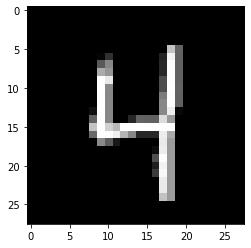

In [16]:
plt.figure(0)
plt.imshow(X_train[91].reshape((28, 28)), cmap='gray', interpolation='none')
print (y_train[91])
plt.show()

**Implementation.** Now code another ```get_acc()``` and try different values of K on our dataset.

In [17]:
def get_acc(kx):
    preds = []
    # print kx
    for ix in range(X_test.shape[0]):
        start = datetime.datetime.now()
        preds.append(knn(X_train, y_train, X_test[ix], k=kx))
        print("Test point: ", str(ix), " runtime: ", str(datetime.datetime.now() - start))
        # print(ix)
        # print(datetime.datetime.now() - start)
    preds = np.asarray(preds)
    
    # print preds.shape
    return 100*float((y_test == preds).sum())/preds.shape[0]

print("Result: ")
# print(get_acc(5))  # k=5 nearest neighbours
print(get_acc(20))  # k=20 nearest neighbours

Result: 
Test point:  0  runtime:  0:00:00.037089
Test point:  1  runtime:  0:00:00.032450
Test point:  2  runtime:  0:00:00.027472
Test point:  3  runtime:  0:00:00.026549
Test point:  4  runtime:  0:00:00.026464
Test point:  5  runtime:  0:00:00.026914
Test point:  6  runtime:  0:00:00.050329
Test point:  7  runtime:  0:00:00.030427
Test point:  8  runtime:  0:00:00.028230
Test point:  9  runtime:  0:00:00.030013
Test point:  10  runtime:  0:00:00.026811
Test point:  11  runtime:  0:00:00.026836
Test point:  12  runtime:  0:00:00.026395
Test point:  13  runtime:  0:00:00.027272
Test point:  14  runtime:  0:00:00.030571
Test point:  15  runtime:  0:00:00.030561
Test point:  16  runtime:  0:00:00.030037
Test point:  17  runtime:  0:00:00.027106
Test point:  18  runtime:  0:00:00.026768
Test point:  19  runtime:  0:00:00.026817
Test point:  20  runtime:  0:00:00.027541
Test point:  21  runtime:  0:00:00.027363
Test point:  22  runtime:  0:00:00.030644
Test point:  23  runtime:  0:00:00.

Test point:  193  runtime:  0:00:00.030020
Test point:  194  runtime:  0:00:00.031187
Test point:  195  runtime:  0:00:00.028567
Test point:  196  runtime:  0:00:00.029457
Test point:  197  runtime:  0:00:00.029992
Test point:  198  runtime:  0:00:00.031491
Test point:  199  runtime:  0:00:00.030188
Test point:  200  runtime:  0:00:00.029630
Test point:  201  runtime:  0:00:00.029932
Test point:  202  runtime:  0:00:00.030706
Test point:  203  runtime:  0:00:00.029161
Test point:  204  runtime:  0:00:00.029868
Test point:  205  runtime:  0:00:00.029461
Test point:  206  runtime:  0:00:00.028250
Test point:  207  runtime:  0:00:00.030830
Test point:  208  runtime:  0:00:00.050740
Test point:  209  runtime:  0:00:00.038020
Test point:  210  runtime:  0:00:00.031781
Test point:  211  runtime:  0:00:00.035553
Test point:  212  runtime:  0:00:00.031489
Test point:  213  runtime:  0:00:00.033983
Test point:  214  runtime:  0:00:00.030883
Test point:  215  runtime:  0:00:00.032196
Test point:

Test point:  386  runtime:  0:00:00.027947
Test point:  387  runtime:  0:00:00.032081
Test point:  388  runtime:  0:00:00.028719
Test point:  389  runtime:  0:00:00.028327
Test point:  390  runtime:  0:00:00.031462
Test point:  391  runtime:  0:00:00.028939
Test point:  392  runtime:  0:00:00.027848
Test point:  393  runtime:  0:00:00.028786
Test point:  394  runtime:  0:00:00.027525
Test point:  395  runtime:  0:00:00.032354
Test point:  396  runtime:  0:00:00.029413
Test point:  397  runtime:  0:00:00.027882
Test point:  398  runtime:  0:00:00.031636
Test point:  399  runtime:  0:00:00.028917
84.5
